# Aplicação de modelos ARIMA para previsão de casos de dengue na cidade de Sorocaba

<hr>

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
os.chdir('../')

import warnings
warnings.simplefilter('ignore')

In [2]:
# leitura e manipulação dos dados
import pandas as pd

# visualização
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# verificação de estacionariedade
from statsmodels.tsa.stattools import adfuller, kpss

# modelagem e diagnósticos
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
default_seaborn_pallete = sns.color_palette() # captura a paleta de cores utilizada pela bilioteca seaborn
from darts.metrics import mase
from darts import TimeSeries
sns.set_palette(default_seaborn_pallete) # ao importar a biblioteca Darts, a paleta de cores do seaborn é modificada. Essa linha de código retorna a paleta anterior
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import kstest, levene

<hr>

## Leitura da base de dados e pré-processamento inicial
Os dados utilizados neste projeto são disponibilizados de forma pública através da API Infodengue.Eles foram obtidos por meio de um script em linguagem Python que é disponibilizado pelos desenvolvedores da API e foi customizado para ser utilizado como uma função. O código utilizado nessa etapa pode ser encontrado no arquivo [data_wrangling.ipynb](./data_wrangling.ipynb).<br>

Foram utilizadas os dados referentes à cidade de Sorocaba que compreendem o período da primeira semana epidemiológica de 2018 (iniciada em 31 de dezembro de 2017) até a trigésima semana epidemiológica de 2023(iniciada em 23 de julho de 2023).<br>
Dentre as variáveis presentes, foram mantidas apenas as variáveis data_iniSE e casos, que contém, respectivamente, o primeiro dia da semana epidemiológica (domingo) e o número de casos notificados na semana.

In [3]:
dengue_data = 'datasets/SOROCABA_SP_3552205_2010-2023.csv'
dengue = pd.read_csv(dengue_data,usecols=['data_iniSE', 'SE', 'casos'])

In [4]:
# selecionando o período de interesse para o trabalho
# *Inicialmente, o objetivo era trabalhar com os dados de 2010 a 2023, 
# mas, durante o desenvolvimento do projeto, verificou-se que seria um período muito longo para o ajuste de um modelo, devido à natureza dos dados, 
# então, optou-se por utilizar dados de 2018 a 2023.
dengue = dengue[dengue['data_iniSE'] >= '2017-12-31']

# ordenamento dos dados em ordem crescente de tempo
dengue['data_iniSE'] = pd.to_datetime(dengue['data_iniSE'])
dengue.rename(columns={'data_iniSE' : 'data'}, inplace=True)
dengue.sort_values(by='data', inplace=True)
dengue.reset_index(drop=True, inplace=True)

In [5]:
# verificando se a frequência entre as medições é a mesma
dengue['diff'] = dengue['data'].diff().dt.days
display(dengue[dengue['diff'] != dengue['diff'].iloc[1]])

# ao olhar o intervalo de dados próximo à medição com frequência diferente, verifica-se pela coluna SE que a data provavelmente está errada. 
# levando em conta isso, e por ser uma única observação com esse comportamento, optou-se por corrigir a data
display(dengue.iloc[12:16])

# corrigindo a data
dengue.loc[dengue.loc[dengue['data'] == '2018-04-04'].index, 'data'] = '2018-04-08' 
display(dengue.iloc[12:16])
# removendo as colunas que não serão utilizadas
dengue.drop(columns=['SE', 'diff'], inplace=True)
display(dengue)

,data,SE,casos,diff
0,2017-12-31,201801,117,NaN
14,2018-04-04,201815,81,3.0
15,2018-04-15,201816,64,11.0


,data,SE,casos,diff
12,2018-03-25,201813,73,7.0
13,2018-04-01,201814,106,7.0
14,2018-04-04,201815,81,3.0
15,2018-04-15,201816,64,11.0


,data,SE,casos,diff
12,2018-03-25,201813,73,7.0
13,2018-04-01,201814,106,7.0
14,2018-04-08,201815,81,3.0
15,2018-04-15,201816,64,11.0


,data,casos
0,2017-12-31,117
1,2018-01-07,111
2,2018-01-14,154
3,2018-01-21,161
4,2018-01-28,135
...,...,...
286,2023-06-25,340
287,2023-07-02,260
288,2023-07-09,241
289,2023-07-16,123


In [6]:
def split_data(dataframe, train_ratio=None, start_test=None, date_column=None, validation_data = False):
    """
    Divide o dataframe em dados de treino , validação (opcional) e teste.
    --------------------
    Parâmetros:
    dataframe: (Pandas Dataframe) : Dataframe contendo os dados
    train_ratio(float): se fornecido, é utilizado para calcular a fração desejada para os dados de teste
    start_test(str): se fornecido, irá fazer a divisão com os dados de teste iniciando na data informada
    validation_data(bool) | default=False: indica se o dataframe deve ser dividido também em dados de validação 
    --------------------
    Retorno:
    train_data(Pandas Dataframe) : Dataframe com os dados de treino
    valid_data(Pandas Dataframe) (opcional): Caso o parâmetro validation_data seja True, também retorna um dataframe com dados de validação
    test_data(Pandas Dataframe) : Dataframe com os dados de teste
    """
    if train_ratio:
        train_index = int(train_ratio * len(dataframe))
        train_data = dataframe[:train_index]
        test_data = dataframe[train_index:]
    elif start_test and date_column:
        start_test = pd.to_datetime(start_test)
        train_data = dataframe[dataframe[date_column] < start_test]
        test_data = dataframe[dataframe[date_column] >= start_test]
    else:
        raise ValueError("Faltando parâmetros train_ratio, start_test ou date_column")
    
    if validation_data:
        valid_train_size = len(test_data) // 2
        valid_data = test_data[:valid_train_size]
        test_data = test_data[valid_train_size:]
        return train_data, valid_data, test_data
    
    return train_data, test_data

In [8]:
def transform_series(dataframe, index_column, values_column):
    """
    Transforma um dataframe em uma Série, e a ordena em ordem crescente de tempo
    --------------------
    Parametros:
    dataframe (Pandas DataFrame): o dataframe a ser transformado.
    index_column(str): nome da coluna que será usada como índice da série
    values_column(str): nome da coluna que será utilizada como os valores da série
    --------------------
    Retorno:
    timeseries (Pandas Series): a série criada
    """
    dataframe[index_column] = pd.to_datetime(dataframe[index_column])
    timeseries = dataframe.set_index(index_column)[values_column]
    timeseries = timeseries.sort_index()
    return timeseries

In [7]:
start_date_test = '2023-01-01'

train_data, valid_data, test_data = split_data(dengue, start_test=start_date_test, date_column='data', validation_data=True)

In [9]:
dengue_train_series = transform_series(train_data.loc[:,['data', 'casos']], 'data', 'casos')
dengue_valid_series = transform_series(valid_data.loc[:,['data', 'casos']], 'data', 'casos')
dengue_test_series = transform_series(test_data.loc[:,['data', 'casos']], 'data', 'casos')
dengue_train_series = dengue_train_series.asfreq('W') # para a etapa de modelagem é necessário definir a frequência da série

<hr>

## Análise exploratória dos dados

### Visualização dos dados

In [10]:
def lineplot(x, y, xlabel='Time', ylabel='Values', title='Timeseries plot', output_file= None):
    """
    Parâmetros:
    x : Dados que irão compor o eixo x
    y : Dados que irão compor o eixo y
    xlabel(str) | (opcional) default: Time : Rótulo do eixo x
    ylabel(str) | (opcional) default: Values : Rótulo do eixo y
    title(str)  | (opcional) default: Timeseries plot : Título do gráfico
    output_file (str) | (opcional) default: None : Caminho (incluindo nome do arquivo) para salvar o gráfico como imagem
    --------------------
    Exibe um gráfico de linhas da série
    """
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(x, y)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(100))
    ax.grid(False)
    plt.xlabel(xlabel, fontsize=14, fontweight='normal', color='black')
    plt.ylabel(ylabel, fontsize=14, fontweight='normal', color='black')
    plt.title(title, fontsize=16, color='black')
    ax.tick_params(axis='both', labelsize=12, colors='black')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, format='png', dpi=600)

    plt.show()

In [11]:
def seasonal_boxplot(serie, title, x_label, y_label, output_file = None):
    """
    Parâmetros:
    serie(Pandas Series): Série temporal
    title(str): Título do gráfico
    xlabel(str): Rótulo do eixo x
    ylabel(str): Rótulo do eixo y
    output_file(str) | (opcional) default: None  : Caminho (incluindo nome do arquivo) para salvar o gráfico como imagem
    --------------------
    Exibe um gráfico boxplot sazonal com os dados agrupados por mês
    """
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(15, 5))
    ax = sns.boxplot(y=serie.values, x=serie.index.month, orient='v', palette="viridis")

    ax.set_title(title, fontsize=16, color='black')
    ax.set_xlabel(x_label, fontsize=14, fontweight='normal', color='black')
    ax.set_ylabel(y_label, fontsize=14, fontweight='normal', color='black')
    ax.tick_params(axis='both', labelsize=14, colors='black')
    ax.set_facecolor('white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.grid(False)
    
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, format='png', dpi=600)
    
    plt.show()

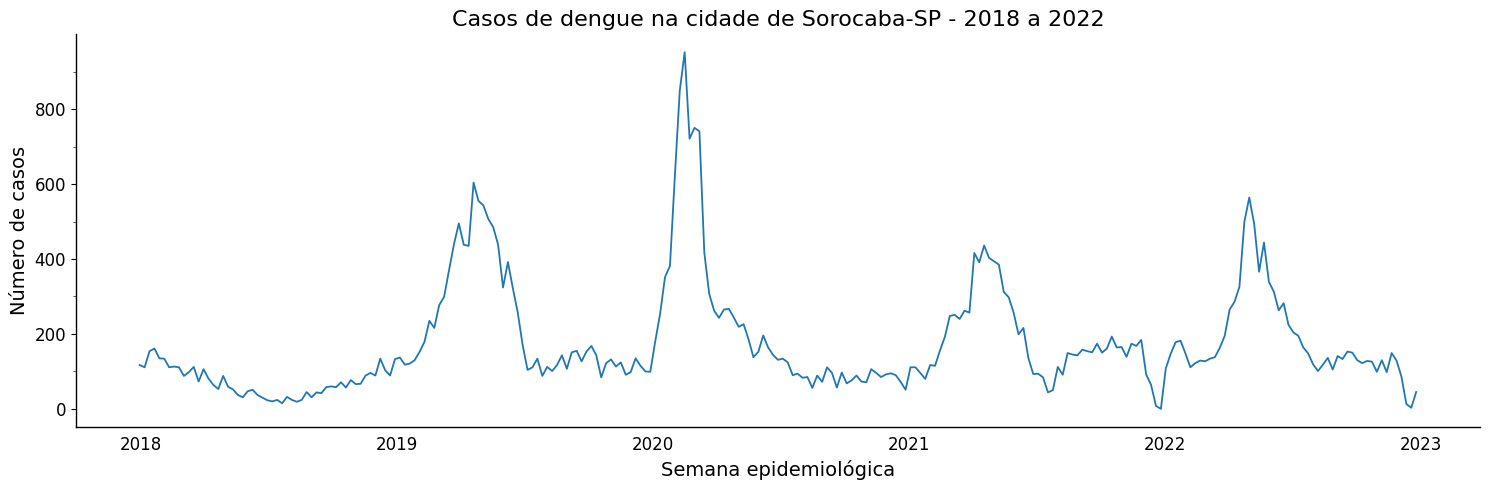

In [12]:
lineplot(dengue_train_series.index, dengue_train_series.values, title='Casos de dengue na cidade de Sorocaba-SP - 2018 a 2022', ylabel='Número de casos', xlabel='Semana epidemiológica') #, output_file='images/lineplot_dengue.png')

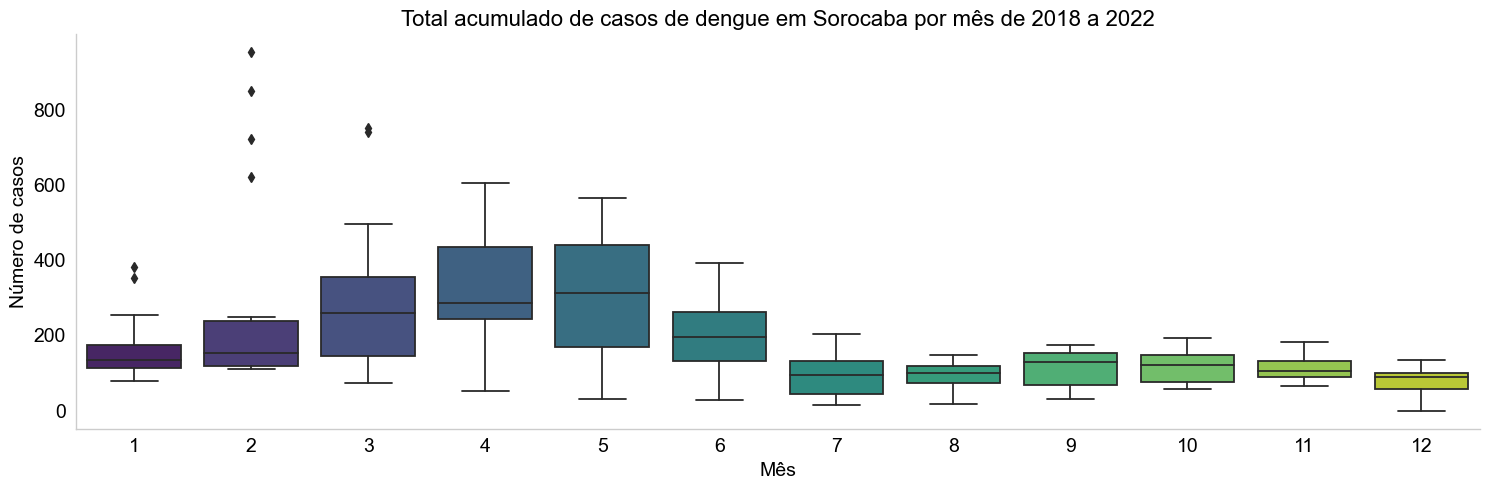

In [13]:
seasonal_boxplot(dengue_train_series, "Total acumulado de casos de dengue em Sorocaba por mês de 2018 a 2022", "Mês", "Número de casos") #, output_file='images/boxplot-dengue.png')

A partir da análise dos gráficos, verifica-se que o número de casos não é constante ao longo do ano, apresentando volume maior nos meses iniciais de cada ano.

### Verificação da Estacionariedade

In [14]:
def adf_test(timeseries):
    """
    Parâmetros:
    timeseries(Pandas Series): série temporal
    --------------------
    O teste ADF é usado para determinar a presença de raiz unitária na série,
    e assim ajudar a entender se a série é estacionária ou não.
    As hipóteses nula e alternativa para esse teste são:
    - H0(hipótese nula): A série possui raiz unitária;
    - H1(hipótese alternativa): A série não possui raiz unitária.
    Se a hipótese nula for aceita é uma evidência de não estacionariedade da série.

    O número de lags utilizados na estatística de teste é escolhido para minimizar o critério de informação AIC.
    --------------------
    Retorno:
    dfoutput(Pandas Dataframe): dataframe contendo os resultados obtidos
    --------------------
    Esta função foi obtida em: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#ADF-test
    """
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    return dfoutput

In [15]:
def kpss_test(timeseries):
    """
    Parâmetros:
    timeseries(Pandas Series): série temporal
    --------------------
    O teste KPSS é utilizado para verificar a estacionariedade de uma série temporal.
    As hipóteses nula e alternativa para esse teste são:
    - H0(hipótese nula): O processo (série temporal) é estacionário na tendência.
    - H1(hipótese alternativa): A série possui raiz unitária, ou seja, é não estacionária.
    --------------------
    Retorno:
    kpss_output(Pandas Dataframe): dataframe contendo os resultados obtidos
    --------------------
    Esta função foi obtida em: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#KPSS-test
    """
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

    return kpss_output

In [16]:
df_adf = adf_test(dengue_train_series)
print('\nA série é estacionária.' if df_adf['p-value'] < 0.05 else 'A série não é estacionária.')
print('---------------------------------')
df_kpss = kpss_test(dengue_train_series)
print('A série não é estacionária.' if df_kpss['p-value'] < 0.05 else 'A série é estacionária.')

Results of Dickey-Fuller Test:
Test Statistic                  -4.716061
p-value                          0.000078
#Lags Used                       4.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64

A série é estacionária.
---------------------------------
Results of KPSS Test:
Test Statistic            0.118546
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
A série é estacionária.


C:\Users\amand\AppData\Local\Temp\ipykernel_19164\1472991643.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries)


A partir dos resultados dos testes ADF e KPSS, verifica-se que a série é estacionária.

### Autocorrelação e autocorrelação parcial

In [17]:
def plot_acf_pacf(timeseries, lags=24, output_file=None):
    """
    Parâmetros:
    timeseries(Pandas Series): A série temporal
    lags(int): O número de lags que se deseja plotar
    output_file(str) | (opcional) default: None  : Caminho (incluindo nome do arquivo) para salvar o gráfico como imagem

    -------------------------------------------------------------
    Plota os gráficos de Autocorrelação(ACF) e Autocorrelação Parcial(PACF) para a Série Temporal
    -------------------------------------------------------------
    Referências:
    https://www.statsmodels.org/devel/generated/statsmodels.graphics.tsaplots.plot_acf.html
    https://www.statsmodels.org/devel/generated/statsmodels.graphics.tsaplots.plot_pacf.html
    """
    color = 'C0'
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8), facecolor='white')
    _ = plot_acf(timeseries, lags=lags, ax=ax[0], color=color, vlines_kwargs={"color": color}, title="Autocorrelação", marker=None)
    _ = plot_pacf(timeseries, lags=lags, ax=ax[1], color=color, vlines_kwargs={"color": color}, title="Autocorrelação Parcial", marker=None)
    ax[0].grid(False)
    ax[1].grid(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, format='png', dpi=600)

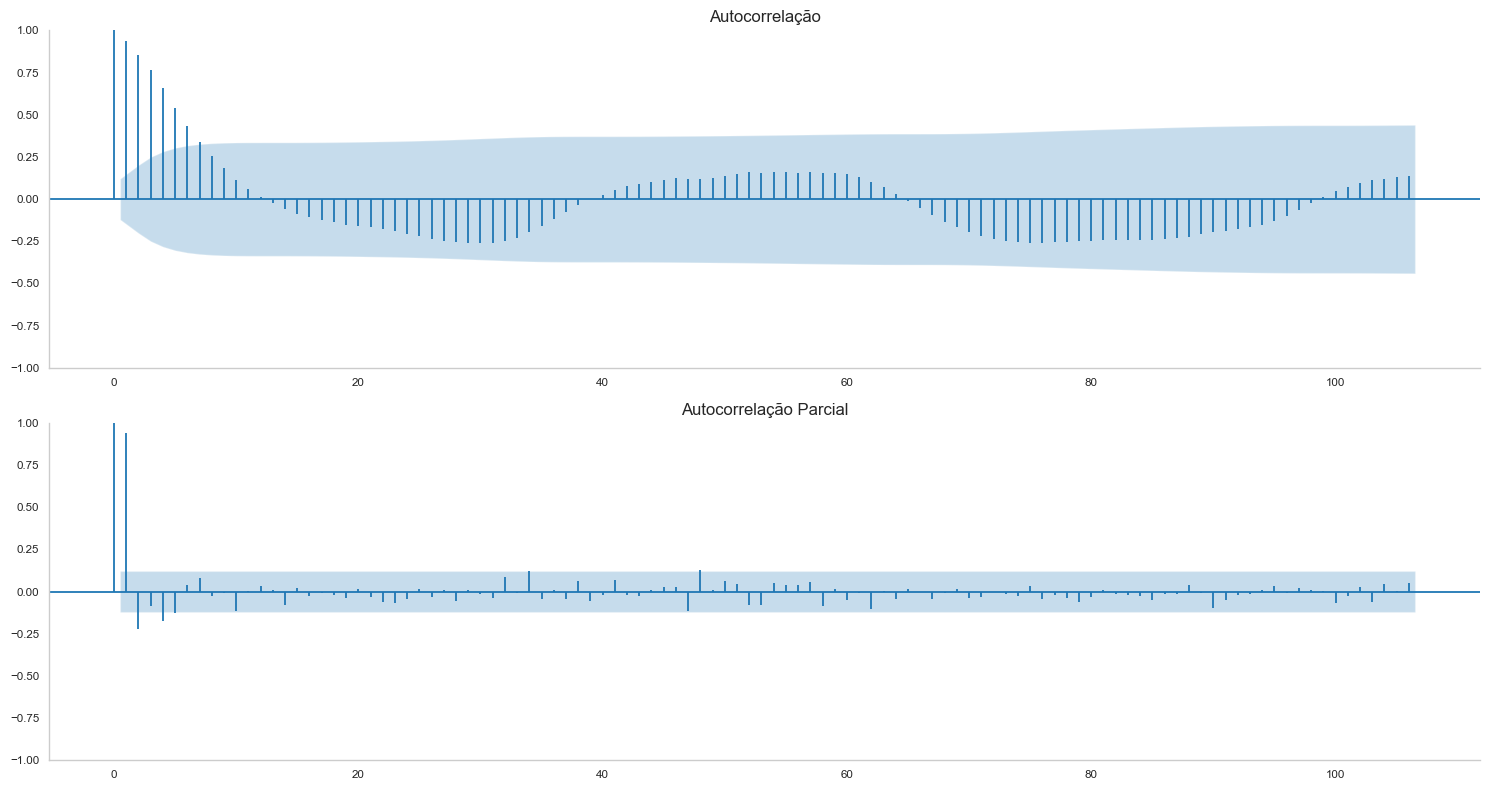

In [18]:
plot_acf_pacf(dengue_train_series, lags=106) #, output_file='images/acf_pacf_dengue.png')

<hr>

## Modelagem Univariada utilizando modelos ARIMA

### Estimação de parâmetros utilizando a biblioteca Auto Arima

In [19]:
# supondo uma série não sazonal
auto_arima = pm.auto_arima(dengue_train_series,
                                 start_p=0, start_q=0, 
                                 max_p=5, max_q=5, seasonal=False,
                                 trace=True,
                                 stepwise=True, # suprime os avisos de convergência
                                 suppress_warnings=True, # suprime os erros caso uma ordem testada não funcione
                                  error_action='ignore')   # Indica se deve utilizar o algoritmo stepwise proposto por Hyndman and Khandakar (2008) 
                                            # para idenficar os parâmetros ótimos para o modelo.
                                            # O algoritmo stepwise pode ser significativamente mais rápido do que ajustar todos os (ou um subconjunto aleatório de) 
                                            # combinações de hiperparâmetros e é menos provável que sobreajuste o modelo.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3586.353, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2800.793, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3287.617, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2792.577, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2793.429, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2790.654, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2793.680, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2792.632, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2792.616, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2795.094, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2787.159, Time=0.66 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2783.054, Time=0.51 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2790.590, Time=0.37 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2784.926, Time=1.18 sec
 ARIMA(4,0,3)(0,0,0)[0]          

In [20]:
# supondo uma série sazonal, com sazonalidade m=52
auto_arima_sarima_model = pm.auto_arima(dengue_train_series,
                                 start_p=0, start_q=0, 
                                 start_P=0, start_Q=0,
                                 max_p=5, max_q=5, 
                                 max_P=5, max_Q=5, seasonal=True, m=52,
                                 trace=True,
                                 suppress_warnings=True, # suprime os avisos de convergência
                                 error_action='ignore', # suprime os erros caso uma ordem testada não funcione
                                 stepwise=True) # Indica se deve utilizar o algoritmo stepwise proposto por Hyndman and Khandakar (2008) 
                                            # para idenficar os parâmetros ótimos para o modelo.
                                            # O algoritmo stepwise pode ser significativamente mais rápido do que ajustar todos os (ou um subconjunto aleatório de) 
                                            # combinações de hiperparâmetros e é menos provável que sobreajuste o modelo.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3360.030, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2798.220, Time=2.19 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3094.720, Time=1.64 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3586.353, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2797.683, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2798.244, Time=1.57 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2800.199, Time=2.84 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=2786.999, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2787.261, Time=3.56 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=2787.269, Time=1.63 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=2789.263, Time=2.31 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=2786.619, Time=0.14 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=2786.600, Time=3.75 sec
 ARIMA(3,0,0)(2,0,0)[52] intercept   : AIC=2788.506, Time=56.64 sec
 ARIMA(3,0,0)(1,0,

### Estimação e ajuste dos modelos

A etapa a seguir, é composta pela estimação de modelos utilizando diferentes parâmetros, incluindo os modelos sugeridos como os melhores pelo método auto_arima.<br>
A seguir, é aplicado o teste de Ljung-Box nos resíduos de cada modelo, para verificar se eles são autocorrelacionados.<br>
Caso o modelo apresente resíduos autocorrelacionados, é um indício de que ele não foi capaz de capturar todas as informações que deveriam ter sido extraídas dos dados, sendo considerado, portanto, não adequado.<br>
Também é útil, mas não obrigatório, que os resíduos contenham média zero e variância constante. Caso isso não ocorra, é um indício de que as previsões sejam tendenciosas e de presença de heterocedasticidade, respectivamente.<br>
Para essa verificação, são aplicados o teste de Kolmogorov-Smirnov (teste KS), o teste de Levene e o teste Multiplicador de Lagrange (teste LM) para heterocedasticidade condicional autorregressiva.


In [21]:
# definindo a quantidade de lags desejados para calcular o teste de ljung-box
seasonal_lags = len(dengue_train_series)//5
seasonal_lags
# https://robjhyndman.com/hyndsight/ljung-box-test/

52

In [22]:
def test_ljungbox(resid, lags=10):
    # https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html#statsmodels.stats.diagnostic.acorr_ljungbox
    res = acorr_ljungbox(resid, lags=lags, return_df=True)
    res['result'] = res['lb_pvalue'].apply(lambda x: 'H0 aceita' if x > 0.05 else 'H0 rejeitada')
    print("=============================================")
    print("              Teste Ljung-Box")
    print("=============================================")
    print("H0: Os resíduos não são autocorrelacionados")
    print("H1: Os resíduos são autocorrelacionados.")
    print("=============================================")
    print(res)


def test_levene(resid, samples):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
    print("=========================")
    print("    Teste de Levene")
    print("=========================")
    samples = np.array_split(resid, samples)
    res = levene(*samples)
    print("H0: As variâncias das sub-amostras são iguais, a série é homocedástica.\nH1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.")
    print(f"Estatística de teste: {res[0]}\np-value: {res[1]}")
    print("Resultado: {}".format('H0 Aceita' if res.pvalue > 0.05 else 'H0 Rejeitada'))


def test_ks(resid, nobs=52):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
    res = kstest(resid, 'norm', N=nobs)
    print("=========================")
    print("    Teste de Kolmorogov-Smirnov")
    print("=========================")
    print("H0: Os resíduos possuem distribuição normal\nH1: Os resíduos não possuem distribuição normal")
    print(f"Estatística de teste:{res[0]}")
    print(f"p-valor:{res[1]}")
    print('H0 aceita' if res[1] > 0.05 else "H0 rejeitada")


def test_arch_test(resid):
    # https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.het_arch.html
    res = het_arch(resid)
    print("=========================")
    print("    LM Arch Test")
    print("=========================")
    print("H0: Os resíduos são homocedásticos\nH1: Os resíduos são heterocedásticos")
    print(f"Lagrange Multiplier test statistic : {res[0]}")
    print(f"p-value for LM-test: {res[1]}")
    print(f"Statistic for F test: {res[2]}")
    print(f"p-value for F test: {res[3]}")
    print("H0 aceita." if res[1] > 0.05 else "H0 rejeitada." )

#### AR (1)

In [23]:
m_ar1 = ARIMA(dengue_train_series, order=(1,0,0)).fit()
m_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1395.841
Date:                Tue, 30 Jan 2024   AIC                           2797.683
Time:                        07:22:13   BIC                           2808.376
Sample:                    12-31-2017   HQIC                          2801.981
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        166.9535     78.207      2.135      0.033      13.671     320.236
ar.L1          0.9394      0.013     72.304      0.000       0.914       0.965
sigma2      2565.7207    100.562     25.514      0.000    2368.622    2762.819
===================================================================================
Ljung-Box (L1) (Q):                  11.41   Jarque-Bera (JB):               983.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.64
Prob(H) (two-sided):                  0.17   Kurtosis:                        12.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
test_ljungbox(m_ar1.resid, lags=seasonal_lags)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue        result
1   11.384843   0.000740  H0 rejeitada
2   14.161874   0.000841  H0 rejeitada
3   21.604596   0.000079  H0 rejeitada
4   25.600204   0.000038  H0 rejeitada
5   26.425535   0.000074  H0 rejeitada
6   32.000273   0.000016  H0 rejeitada
7   32.637470   0.000031  H0 rejeitada
8   34.626649   0.000031  H0 rejeitada
9   34.695461   0.000067  H0 rejeitada
10  36.771227   0.000062  H0 rejeitada
11  39.720378   0.000040  H0 rejeitada
12  40.911857   0.000051  H0 rejeitada
13  40.949974   0.000097  H0 rejeitada
14  43.090607   0.000083  H0 rejeitada
15  44.376242   0.000096  H0 rejeitada
16  44.534009   0.000164  H0 rejeitada
17  44.688596   0.000271  H0 rejeitada
18  44.713259   0.000456  H0 rejeitada
19  45.877411   0.000516  H0 rejeitada
20  45.909298   0.000829  H0 rejeitada
21  46.096394   0.001241  H0 rejeitada
22  46.682131   0.001614  H

Verifica-se que o modelo não é adequado, pois os resíduos estão correlacionados.

#### AR(2)

In [25]:
m_ar2 = ARIMA(dengue_train_series, order=(2,0,0)).fit()
m_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1389.511
Date:                Tue, 30 Jan 2024   AIC                           2787.022
Time:                        07:22:13   BIC                           2801.280
Sample:                    12-31-2017   HQIC                          2792.753
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2803     61.829      2.867      0.004      56.097     298.463
ar.L1          1.1446      0.035     32.971      0.000       1.077       1.213
ar.L2         -0.2179      0.038     -5.771      0.000      -0.292      -0.144
sigma2      2443.0037    108.391     22.539      0.000    2230.562    2655.445
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               806.85
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.48
Prob(H) (two-sided):                  0.28   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
test_ljungbox(m_ar2.resid, lags=52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue        result
1    0.068796   0.793097     H0 aceita
2    0.593411   0.743263     H0 aceita
3    6.385307   0.094297     H0 aceita
4   10.474068   0.033156  H0 rejeitada
5   10.850752   0.054421     H0 aceita
6   14.348013   0.025981  H0 rejeitada
7   14.401386   0.044486  H0 rejeitada
8   15.609127   0.048329  H0 rejeitada
9   15.867529   0.069700     H0 aceita
10  16.871233   0.077262     H0 aceita
11  18.249130   0.075977     H0 aceita
12  18.862392   0.091904     H0 aceita
13  19.530152   0.107561     H0 aceita
14  21.358825   0.092784     H0 aceita
15  21.978925   0.108358     H0 aceita
16  21.991591   0.143463     H0 aceita
17  22.101307   0.180854     H0 aceita
18  22.117555   0.226808     H0 aceita
19  23.406267   0.219921     H0 aceita
20  23.415656   0.268849     H0 aceita
21  23.472122   0.319332     H0 aceita
22  23.834000   0.355991   

Verifica-se que o modelo não é adequado, pois os resíduos estão correlacionados.

#### AR (4)

In [27]:
m_ar4 = ARIMA(dengue_train_series, order=(4,0,0)).fit()
m_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1383.618
Date:                Tue, 30 Jan 2024   AIC                           2779.237
Time:                        07:22:13   BIC                           2800.624
Sample:                    12-31-2017   HQIC                          2787.834
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2924     47.448      3.737      0.000      84.297     270.288
ar.L1          1.1049      0.040     27.895      0.000       1.027       1.183
ar.L2         -0.1281      0.074     -1.736      0.083      -0.273       0.017
ar.L3          0.1168      0.074      1.582      0.114      -0.028       0.262
ar.L4         -0.1881      0.032     -5.924      0.000      -0.250      -0.126
sigma2      2333.6685    120.656     19.341      0.000    2097.186    2570.150
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               613.96
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.47
Prob(H) (two-sided):                  0.20   Kurtosis:                        10.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
test_ljungbox(m_ar4.resid, 52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.107771   0.742696  H0 aceita
2    0.111074   0.945977  H0 aceita
3    0.112073   0.990350  H0 aceita
4    4.789059   0.309634  H0 aceita
5    4.914450   0.426410  H0 aceita
6    9.695183   0.138089  H0 aceita
7    9.865107   0.196347  H0 aceita
8    9.880075   0.273544  H0 aceita
9   12.314502   0.196154  H0 aceita
10  12.765182   0.237099  H0 aceita
11  13.083234   0.287920  H0 aceita
12  13.186601   0.355625  H0 aceita
13  15.062259   0.303482  H0 aceita
14  15.881915   0.320639  H0 aceita
15  16.282290   0.363543  H0 aceita
16  16.287126   0.433107  H0 aceita
17  16.288512   0.503482  H0 aceita
18  16.325568   0.569837  H0 aceita
19  18.231973   0.506996  H0 aceita
20  18.280829   0.568915  H0 aceita
21  18.397655   0.623719  H0 aceita
22  18.926006   0.649893  H0 aceita
23  18.941399   0.704621  H0 aceita
24  19.921173   0.701

In [29]:
test_ks(m_ar4.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.5324710619181742
p-valor:1.2646983607356352e-69
H0 rejeitada


In [30]:
test_levene(m_ar4.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 5.958270154094053
p-value: 1.480581846622891e-07
Resultado: H0 Rejeitada


In [31]:
test_arch_test(m_ar4.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 78.28187104643962
p-value for LM-test: 1.0892199885734751e-12
Statistic for F test: 10.877635813318147
p-value for F test: 3.1633451986987417e-15
H0 rejeitada.


Verifica-se que o modelo não possui resíduos autocorrelacionados, o que indica que ele conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade

#### ARMA(2,1)

In [32]:
m_arma21 = ARIMA(dengue_train_series, order=(2,0,1)).fit()
m_arma21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1384.754
Date:                Tue, 30 Jan 2024   AIC                           2779.509
Time:                        07:22:14   BIC                           2797.331
Sample:                    12-31-2017   HQIC                          2786.673
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2885     42.302      4.191      0.000      94.378     260.199
ar.L1          1.7557      0.099     17.800      0.000       1.562       1.949
ar.L2         -0.7920      0.093     -8.490      0.000      -0.975      -0.609
ma.L1         -0.6639      0.125     -5.304      0.000      -0.909      -0.419
sigma2      2354.7467    114.011     20.654      0.000    2131.289    2578.204
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               824.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.32
Prob(H) (two-sided):                  0.24   Kurtosis:                        11.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
test_ljungbox(m_arma21.resid, lags=52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.000460   0.982891  H0 aceita
2    0.893768   0.639618  H0 aceita
3    3.300860   0.347523  H0 aceita
4    6.147487   0.188401  H0 aceita
5    7.223621   0.204533  H0 aceita
6   11.761547   0.067505  H0 aceita
7   11.861751   0.105198  H0 aceita
8   11.964250   0.152806  H0 aceita
9   13.554896   0.139063  H0 aceita
10  13.612130   0.191430  H0 aceita
11  14.000745   0.232952  H0 aceita
12  14.001682   0.300601  H0 aceita
13  16.337090   0.231405  H0 aceita
14  16.890916   0.262038  H0 aceita
15  17.102042   0.312801  H0 aceita
16  17.181790   0.373929  H0 aceita
17  17.189158   0.441623  H0 aceita
18  17.252783   0.505795  H0 aceita
19  18.503223   0.489094  H0 aceita
20  18.526731   0.552752  H0 aceita
21  18.702474   0.604219  H0 aceita
22  19.262672   0.629057  H0 aceita
23  19.275193   0.685141  H0 aceita
24  19.898896   0.702

In [34]:
test_ks(m_arma21.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.5392319703568476
p-valor:1.5235062456553425e-71
H0 rejeitada


In [35]:
test_levene(m_arma21.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 4.971489444578181
p-value: 3.6693607948812275e-06
Resultado: H0 Rejeitada


In [36]:
test_arch_test(m_arma21.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 68.87747151100854
p-value for LM-test: 7.299594928096317e-11
Statistic for F test: 9.07663280308633
p-value for F test: 1.1153856030994567e-12
H0 rejeitada.


Verifica-se que o modelo não possui resíduos autocorrelacionados, o que indica que ele conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade.

#### ARMA (2,4)

In [37]:
m_arma24 = ARIMA(dengue_train_series, order=(2,0,4)).fit()
m_arma24.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1379.587
Date:                Tue, 30 Jan 2024   AIC                           2775.173
Time:                        07:22:14   BIC                           2803.689
Sample:                    12-31-2017   HQIC                          2786.636
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2910     49.107      3.610      0.000      81.042     273.539
ar.L1          1.0187      0.420      2.424      0.015       0.195       1.842
ar.L2         -0.1690      0.384     -0.440      0.660      -0.921       0.583
ma.L1          0.0551      0.445      0.124      0.902      -0.818       0.928
ma.L2          0.1682      0.078      2.145      0.032       0.014       0.322
ma.L3          0.2651      0.066      4.002      0.000       0.135       0.395
ma.L4          0.2156      0.118      1.827      0.068      -0.016       0.447
sigma2      2260.9649    132.626     17.048      0.000    2001.023    2520.907
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               510.60
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.59
Prob(H) (two-sided):                  0.25   Kurtosis:                         9.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
test_ljungbox(m_arma24.resid, 52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.012833   0.909806  H0 aceita
2    0.059315   0.970778  H0 aceita
3    0.060536   0.996110  H0 aceita
4    0.129713   0.997986  H0 aceita
5    0.511801   0.991685  H0 aceita
6    1.355557   0.968506  H0 aceita
7    2.481824   0.928460  H0 aceita
8    2.508918   0.961314  H0 aceita
9    3.459527   0.943266  H0 aceita
10   3.827103   0.954810  H0 aceita
11   4.752196   0.942571  H0 aceita
12   4.977887   0.958713  H0 aceita
13   6.027494   0.945147  H0 aceita
14   6.880531   0.939219  H0 aceita
15   7.048332   0.956295  H0 aceita
16   7.064531   0.971997  H0 aceita
17   7.107845   0.982109  H0 aceita
18   7.115803   0.989113  H0 aceita
19   9.246144   0.969164  H0 aceita
20   9.336820   0.978668  H0 aceita
21   9.403599   0.985666  H0 aceita
22  10.124283   0.985142  H0 aceita
23  10.126228   0.990469  H0 aceita
24  10.945505   0.989

In [39]:
test_ks(m_arma24.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.5320600194532594
p-valor:1.6503982193306903e-69
H0 rejeitada


In [40]:
test_levene(m_arma24.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 5.66130743625525
p-value: 3.886191768244108e-07
Resultado: H0 Rejeitada


In [41]:
test_arch_test(m_arma24.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 65.64327265618647
p-value for LM-test: 3.052642733391754e-10
Statistic for F test: 8.499494819123745
p-value for F test: 7.654679627649413e-12
H0 rejeitada.


Verifica-se que o modelo não possui resíduos autocorrelacionados, o que indica que ele conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade.

#### ARMA (3,2)

In [42]:
m_arma32 = ARIMA(dengue_train_series, order=(3,0,2)).fit()
m_arma32.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1383.404
Date:                Tue, 30 Jan 2024   AIC                           2780.808
Time:                        07:22:15   BIC                           2805.760
Sample:                    12-31-2017   HQIC                          2790.838
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.5706     12.162     15.341      0.000     162.734     210.407
ar.L1          2.6730      0.146     18.252      0.000       2.386       2.960
ar.L2         -2.3886      0.283     -8.439      0.000      -2.943      -1.834
ar.L3          0.7140      0.138      5.170      0.000       0.443       0.985
ma.L1         -1.5944      0.235     -6.773      0.000      -2.056      -1.133
ma.L2          0.5952      0.201      2.959      0.003       0.201       0.989
sigma2      2317.2072    295.993      7.829      0.000    1737.071    2897.344
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               784.48
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.38
Prob(H) (two-sided):                  0.30   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
test_ljungbox(m_arma32.resid, 52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.001422   0.969915  H0 aceita
2    0.838978   0.657383  H0 aceita
3    3.439127   0.328743  H0 aceita
4    6.468297   0.166799  H0 aceita
5    7.471892   0.187843  H0 aceita
6   11.925943   0.063641  H0 aceita
7   12.016634   0.100013  H0 aceita
8   12.159993   0.144207  H0 aceita
9   13.610611   0.136866  H0 aceita
10  13.698451   0.187196  H0 aceita
11  14.130150   0.225875  H0 aceita
12  14.131098   0.292415  H0 aceita
13  16.518506   0.222260  H0 aceita
14  16.981065   0.257188  H0 aceita
15  17.104337   0.312666  H0 aceita
16  17.285179   0.367379  H0 aceita
17  17.345569   0.431202  H0 aceita
18  17.568320   0.484412  H0 aceita
19  18.341631   0.499737  H0 aceita
20  18.352937   0.564171  H0 aceita
21  18.817145   0.596869  H0 aceita
22  19.843443   0.592832  H0 aceita
23  19.872796   0.649573  H0 aceita
24  20.120223   0.689

In [44]:
test_ks(m_arma32.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.548744138273637
p-valor:2.663764673240804e-74
H0 rejeitada


In [45]:
test_levene(m_arma32.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 4.644712716159738
p-value: 1.0621507122333432e-05
Resultado: H0 Rejeitada


In [46]:
test_arch_test(m_arma32.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 68.43018091336754
p-value for LM-test: 8.901370743113584e-11
Statistic for F test: 8.995596041761479
p-value for F test: 1.4598253530585904e-12
H0 rejeitada.


Verifica-se que o modelo não possui resíduos autocorrelacionados, o que indica que ele conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade.

#### ARMA(4,2)

In [47]:
m_arma42 = ARIMA(dengue_train_series, order=(4,0,2)).fit()
m_arma42.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  261
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1378.785
Date:                Tue, 30 Jan 2024   AIC                           2773.570
Time:                        07:22:16   BIC                           2802.086
Sample:                    12-31-2017   HQIC                          2785.033
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2883     47.440      3.737      0.000      84.307     270.270
ar.L1          1.7739      0.156     11.381      0.000       1.468       2.079
ar.L2         -1.4927      0.251     -5.936      0.000      -1.986      -1.000
ar.L3          0.9191      0.180      5.113      0.000       0.567       1.271
ar.L4         -0.2859      0.064     -4.458      0.000      -0.412      -0.160
ma.L1         -0.6906      0.175     -3.950      0.000      -1.033      -0.348
ma.L2          0.6432      0.153      4.193      0.000       0.342       0.944
sigma2      2246.7497    131.432     17.094      0.000    1989.148    2504.351
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               471.22
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.58
Prob(H) (two-sided):                  0.24   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
test_ljungbox(m_arma42.resid, lags=52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.003798   0.950862  H0 aceita
2    0.080269   0.960660  H0 aceita
3    0.201303   0.977379  H0 aceita
4    0.355394   0.985963  H0 aceita
5    0.408451   0.995094  H0 aceita
6    0.640487   0.995687  H0 aceita
7    1.542226   0.980812  H0 aceita
8    2.280882   0.971167  H0 aceita
9    3.164046   0.957434  H0 aceita
10   3.282169   0.973982  H0 aceita
11   3.390235   0.984499  H0 aceita
12   3.586909   0.989791  H0 aceita
13   4.379316   0.986447  H0 aceita
14   5.543558   0.976720  H0 aceita
15   5.670238   0.984771  H0 aceita
16   5.721168   0.990837  H0 aceita
17   5.750840   0.994709  H0 aceita
18   5.764035   0.997063  H0 aceita
19   7.636187   0.989972  H0 aceita
20   7.740079   0.993452  H0 aceita
21   7.770306   0.996043  H0 aceita
22   8.415665   0.995876  H0 aceita
23   8.443548   0.997515  H0 aceita
24   9.143412   0.997

In [49]:
test_ks(m_arma42.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.5229664260534802
p-valor:5.5450245415085585e-67
H0 rejeitada


In [50]:
test_levene(m_arma42.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 5.378826161384872
p-value: 9.74308887429948e-07
Resultado: H0 Rejeitada


In [51]:
test_arch_test(m_arma42.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 69.03981880522574
p-value for LM-test: 6.792193191836203e-11
Statistic for F test: 9.106144214880588
p-value for F test: 1.0113685325851108e-12
H0 rejeitada.


Não possui resíduos autocorrelacionados, o que indica que o modelo conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade.

#### SARIMA (5,0,0)(0,0,1)[52]

In [52]:
m_sarima500_001 = ARIMA(dengue_train_series, order=(5,0,0), seasonal_order=(0,0,1,52)).fit()
m_sarima500_001.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              casos   No. Observations:                  261
Model:             ARIMA(5, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -1380.057
Date:                            Tue, 30 Jan 2024   AIC                           2776.115
Time:                                    07:22:19   BIC                           2804.631
Sample:                                12-31-2017   HQIC                          2787.578
                                     - 12-25-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.2849     44.139      4.016      0.000      90.773     263.796
ar.L1          1.0762      0.043     25.291      0.000       0.993       1.160
ar.L2         -0.1061      0.077     -1.372      0.170      -0.258       0.045
ar.L3          0.0928      0.084      1.104      0.269      -0.072       0.258
ar.L4         -0.0341      0.062     -0.550      0.582      -0.156       0.087
ar.L5         -0.1391      0.049     -2.812      0.005      -0.236      -0.042
ma.S.L52       0.1033      0.084      1.229      0.219      -0.061       0.268
sigma2      2265.3567    128.776     17.591      0.000    2012.960    2517.753
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               645.75
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.42
Prob(H) (two-sided):                  0.28   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
test_ljungbox(m_sarima500_001.resid, lags=52)

              Teste Ljung-Box
H0: Os resíduos não são autocorrelacionados
H1: Os resíduos são autocorrelacionados.
      lb_stat  lb_pvalue     result
1    0.029568   0.863474  H0 aceita
2    0.192171   0.908386  H0 aceita
3    0.411383   0.937881  H0 aceita
4    0.553048   0.968135  H0 aceita
5    0.779800   0.978304  H0 aceita
6    5.009415   0.542606  H0 aceita
7    5.116318   0.645771  H0 aceita
8    5.119747   0.744704  H0 aceita
9    7.314052   0.604458  H0 aceita
10   7.315495   0.695362  H0 aceita
11   7.411269   0.764868  H0 aceita
12   7.420225   0.828641  H0 aceita
13   9.454921   0.737784  H0 aceita
14  10.174463   0.749320  H0 aceita
15  10.178087   0.808391  H0 aceita
16  10.204024   0.855759  H0 aceita
17  10.208475   0.894641  H0 aceita
18  10.214635   0.924675  H0 aceita
19  11.313451   0.912844  H0 aceita
20  11.321698   0.937449  H0 aceita
21  11.464631   0.952958  H0 aceita
22  12.160368   0.953978  H0 aceita
23  12.162387   0.967889  H0 aceita
24  12.737167   0.970

In [54]:
test_ks(m_sarima500_001.resid, len(dengue_train_series))

    Teste de Kolmorogov-Smirnov
H0: Os resíduos possuem distribuição normal
H1: Os resíduos não possuem distribuição normal
Estatística de teste:0.5216660318797238
p-valor:1.2598912895431282e-66
H0 rejeitada


In [55]:
test_levene(m_sarima500_001.resid, 10)

    Teste de Levene
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica.
Estatística de teste: 5.218563206252603
p-value: 1.6416424307396436e-06
Resultado: H0 Rejeitada


In [56]:
test_arch_test(m_sarima500_001.resid)

    LM Arch Test
H0: Os resíduos são homocedásticos
H1: Os resíduos são heterocedásticos
Lagrange Multiplier test statistic : 67.98042252909943
p-value for LM-test: 1.0864763289806393e-10
Statistic for F test: 8.914511568893735
p-value for F test: 1.911772466145544e-12
H0 rejeitada.


Não possui resíduos autocorrelacionados, o que indica que o modelo conseguiu se ajustar aos dados, porém, os resíduos não seguem uma distribuição normal e apresentam indícios de heterocedasticidade.

<hr>

## Previsão e Avaliação dos modelos

In [57]:
def forecast_bias(expected, predicted): 
    """
    Parâmetros:
    expected (Pandas Series): Valores esperados
    predicted (Pandas Series): Valores previstos pelo modelo
    ----------
    Calcula o viés da previsão.
    Erros de previsão podem ser positivos ou negativos. Um erro de previsão médio diferente de zero sugere uma tendência do modelo
    a superestimar (erro médio negativo) ou subestimar(erro médio positivo) as previsões.
    Dessa forma, o erro de previsão também é chamado de viés de previsão (Forecast Bias).
    A unidade do viés de previsão é a mesma unidade das previsões.
    Um viés de previsão igual a zero ou muito próximo de zero indica um modelo não viesado.
    ----------
    Retorno:
    Viés da previsão
    """
    sum_expected = sum(expected)
    sum_predicted = sum(predicted)

    return ((sum_expected - sum_predicted) / sum_expected)*100

In [58]:
def rmse(expected, predicted):
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    rmse = mean_squared_error(expected, predicted, squared=False) # Ao utilizar o parâmetro squared=False, ele retorna a raiz do erro quadrático médio (rmse)
    return rmse

In [59]:
def eval_model(model, ts_test, ts_train, steps=None, name=None):
    """
    Parâmetros:
    model : o objeto contendo o algoritmo (modelo) utilizado na predição
    ts_train (Pandas Series): a série com os dados de treino
    ts_test (Pandas Series): a série com os dados de teste
    steps (int): o número de passos que se deseja prever
    name (str): o nome do algoritmo
    ------------------------------
    Retorno:
    y_pred (Pandas Series) : valores previstos
    dicionário com as métricas utilizadas para avaliar o modelo.
    """
    if name is None:
        name = type(model).__name__
    if steps is None:
        steps = len(ts_test)
        
    y_pred = model.forecast(steps)

    ts_test = ts_test[:steps]

    return y_pred, {
        "Model": name,
        "H" : steps,
        "MAE" : mean_absolute_error(ts_test, y_pred),
        "RMSE" : rmse(ts_test, y_pred),
        "MASE" : mase(TimeSeries.from_series(ts_test), TimeSeries.from_series(y_pred), TimeSeries.from_series(ts_train)) if steps > 1 else np.nan,
        "FB" : forecast_bias(ts_test, y_pred),
        "AIC" : model.aic,
    }

In [60]:
def plot_forecast(ts, y_pred, output_file=None, title=None):
    """
    Parâmetros:
    ts (Pandas Series): A série temporal com os valores reais
    y_pred (Pandas Series): Série com os valores previstos
    output_file (str) | (opcional) default: None : Caminho (incluindo nome do arquivo) para salvar o gráfico como imagem
    title (str) | (opcional) default: None : Título desejado para o gráfico
    -------------------------------------------------------------
    Plota um gráfico contendo os valores reais e os valores previstos.
    """
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot()
    ax.plot(ts.index, ts.values, label='Valores observados', color='k')
    ax.plot(y_pred.index, y_pred.values, label='Valores previstos', color='g')
    
    if title is None:
        title = 'Valores observados e valores previstos de dengue'

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(100))
    ax.tick_params(axis='both', labelsize=12, colors='black')
    ax.grid(False)
    plt.legend()

    ax.set_xlabel('Semana epidemiológica', fontsize=14, fontweight='normal', color='black')
    ax.set_ylabel('Número de casos', fontsize=14, fontweight='normal', color='black')

    plt.title(title, fontsize=16, color='black')


    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, format='png', dpi=600)
    plt.show()

In [61]:
all_metrics = []
dengue_series = pd.concat([dengue_train_series,dengue_valid_series]) # treino + validação

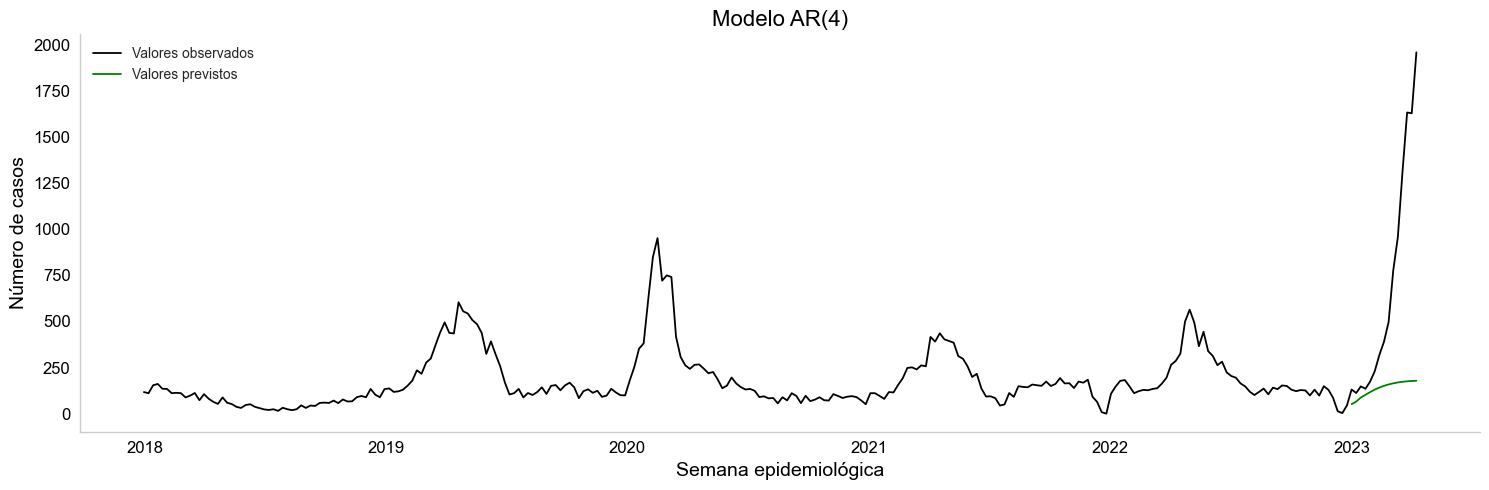

In [62]:
ar4, metrics = eval_model(m_ar4, dengue_valid_series, dengue_train_series, steps=None, name=f"AR(4)")
plot_forecast(dengue_series, ar4, title="Modelo AR(4)") # output_file='images/arima400.png')
all_metrics.append(metrics)

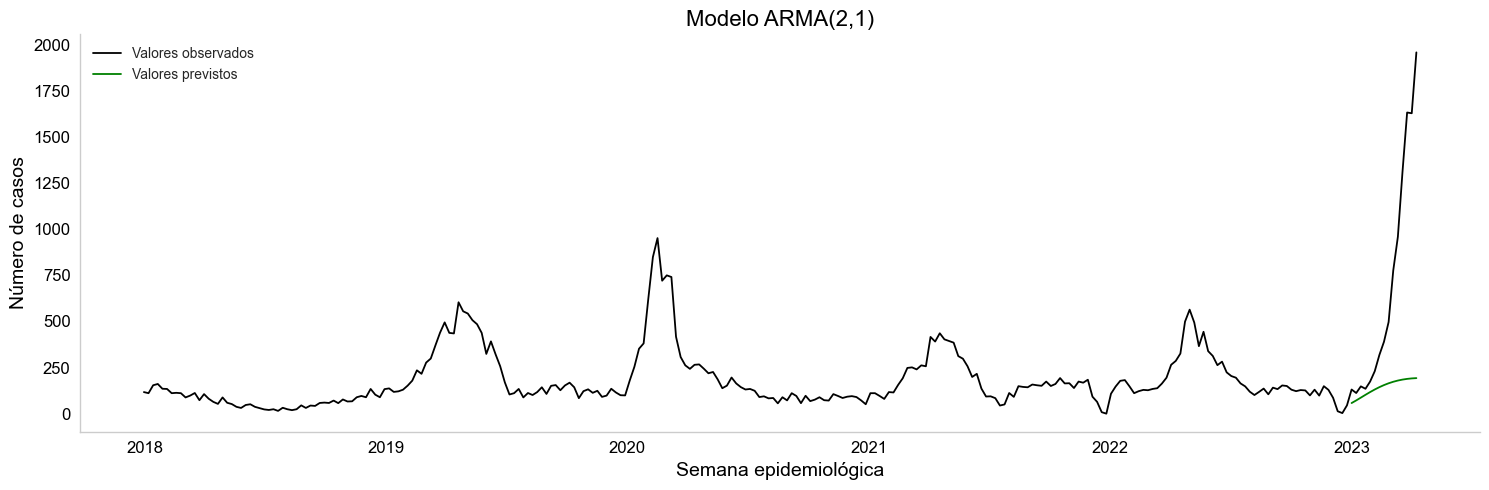

In [63]:
arma21, metrics = eval_model(m_arma21, dengue_valid_series, dengue_train_series, steps=None, name=f"ARMA(2,1)")
plot_forecast(dengue_series, arma21, title="Modelo ARMA(2,1)") #, output_file='images/arima201.png')
all_metrics.append(metrics)

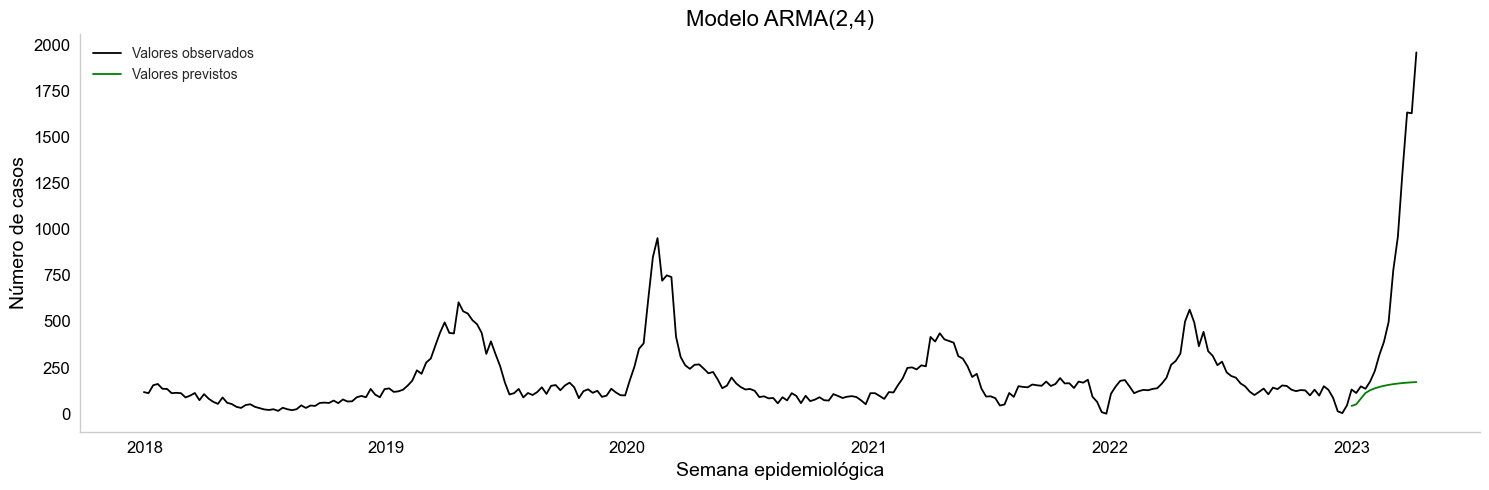

In [64]:
arma24, metrics = eval_model(m_arma24, dengue_valid_series, dengue_train_series, steps=None, name="ARMA(2,4)")
plot_forecast(dengue_series, arma24, title="Modelo ARMA(2,4)") #, output_file='images/arima204.png')
all_metrics.append(metrics)

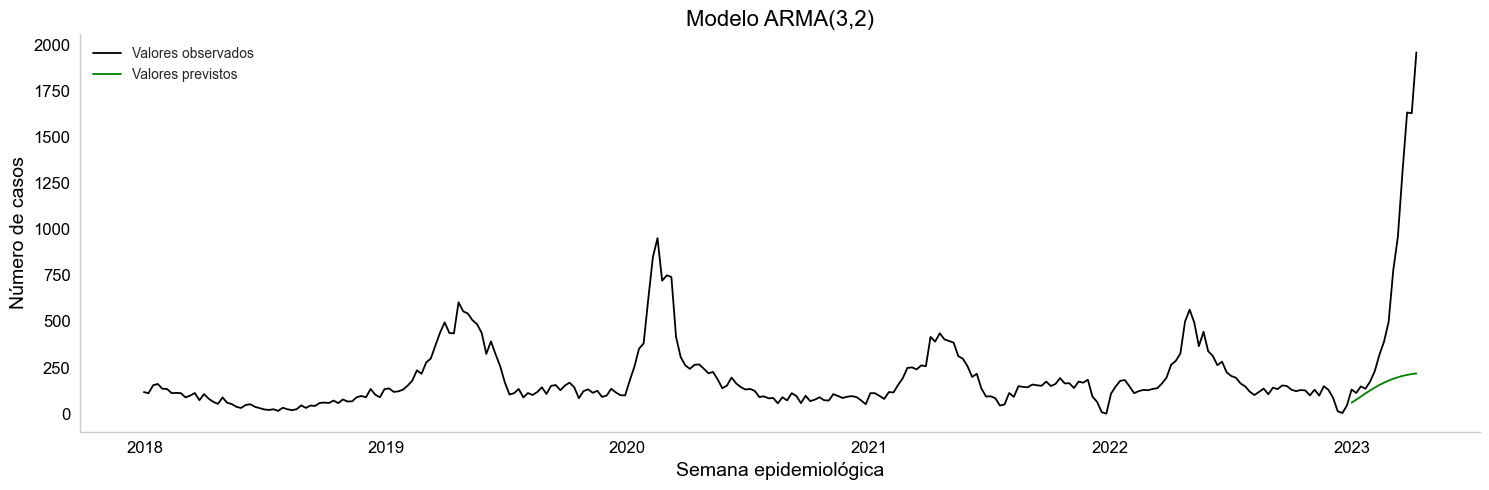

In [65]:
arma32, metrics = eval_model(m_arma32, dengue_valid_series, dengue_train_series, steps=None, name="ARMA(3,2)")
plot_forecast(dengue_series, arma32, title="Modelo ARMA(3,2)") #, output_file='images/arima302.png')
all_metrics.append(metrics)

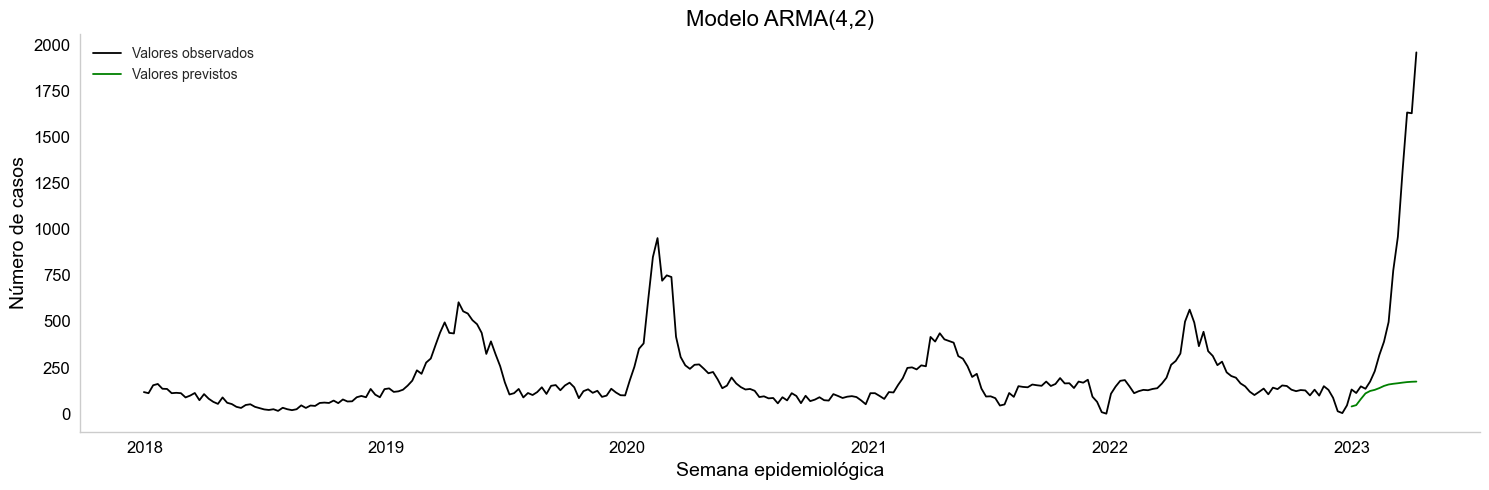

In [66]:
arma42, metrics = eval_model(m_arma42, dengue_valid_series, dengue_train_series, name="ARMA(4,2)")
plot_forecast(dengue_series, arma42, title="Modelo ARMA(4,2)") #, output_file='images/arima402.png')
all_metrics.append(metrics)

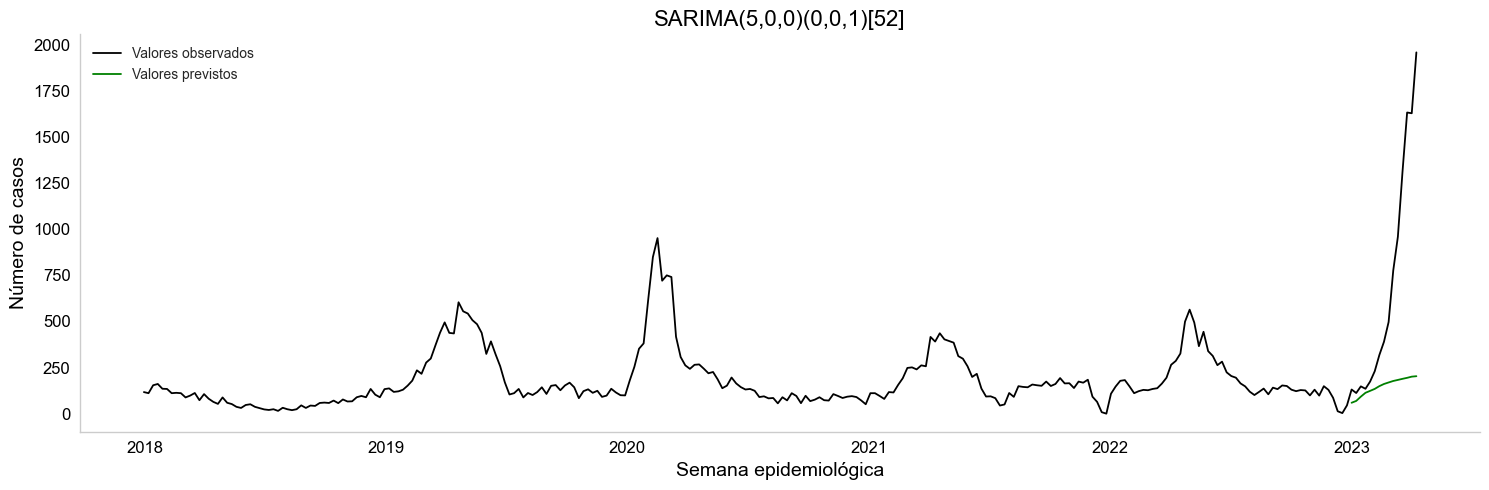

In [67]:
sarima500_001, metrics = eval_model(m_sarima500_001, dengue_valid_series, dengue_train_series, steps=None, name="SARIMA(5,0,0)(0,0,1)[52]")
plot_forecast(dengue_series, sarima500_001, title=f"SARIMA(5,0,0)(0,0,1)[52]") #, output_file='images/sarima500_001.png')
all_metrics.append(metrics)

In [68]:
ar4_h8, metrics = eval_model(m_ar4, dengue_valid_series, dengue_train_series, steps=8, name=f"AR(4)")
all_metrics.append(metrics)

In [69]:
arma21_h8, metrics = eval_model(m_arma21, dengue_valid_series, dengue_train_series, steps=8, name=f"ARMA(2,1)")
all_metrics.append(metrics)

In [70]:
arma24_h8, metrics = eval_model(m_arma24, dengue_valid_series, dengue_train_series, steps=8, name="ARMA(2,4)")
all_metrics.append(metrics)

In [71]:
arma32_h8, metrics = eval_model(m_arma32, dengue_valid_series, dengue_train_series, steps=8, name="ARMA(3,2)")
all_metrics.append(metrics)

In [72]:
arma42_h8, metrics = eval_model(m_arma42, dengue_valid_series, dengue_train_series, steps=8, name="ARMA(4,2)")
all_metrics.append(metrics)

In [73]:
sarima500_001_h8, metrics = eval_model(m_sarima500_001, dengue_valid_series, dengue_train_series, steps=8, name="SARIMA(5,0,0)(0,0,1)[52]")
all_metrics.append(metrics)

In [74]:
ar4_h4, metrics = eval_model(m_ar4, dengue_valid_series, dengue_train_series, steps=4, name=f"AR(4)")
all_metrics.append(metrics)

In [75]:
arma21_h4, metrics = eval_model(m_arma21, dengue_valid_series, dengue_train_series, steps=4, name=f"ARMA(2,1)")
all_metrics.append(metrics)

In [76]:
arma24_h4, metrics = eval_model(m_arma24, dengue_valid_series, dengue_train_series, steps=4, name="ARMA(2,4)")
all_metrics.append(metrics)

In [77]:
arma32_h4, metrics = eval_model(m_arma32, dengue_valid_series, dengue_train_series, steps=4, name="ARMA(3,2)")
all_metrics.append(metrics)

In [78]:
arma42_h4, metrics = eval_model(m_arma42, dengue_valid_series, dengue_train_series, steps=4, name="ARMA(4,2)")
all_metrics.append(metrics)

In [79]:
sarima500_001_h4, metrics = eval_model(m_sarima500_001, dengue_valid_series, dengue_train_series, steps=4, name="SARIMA(5,0,0)(0,0,1)[52]")
all_metrics.append(metrics)

A tabela a seguir contêm os valores de MAE, RMSE, MASE, FB e AIC para cada modelo, para diferentes horizontes de previsão (H).

In [80]:
pd.DataFrame(all_metrics).style.format({
                                        "MAE" : "{:.3f}", 
                                        "RMSE" : "{:.3f}", 
                                        "MASE" : "{:.3f}", 
                                        "FB" : "{:.3f}", 
                                        "AIC" : "{:.3f}", 
})

,Model,H,MAE,RMSE,MASE,FB,AIC
0,AR(4),15,557.280,813.426,17.233,80.362,2779.237
1,"ARMA(2,1)",15,550.828,805.564,17.033,79.431,2779.509
2,"ARMA(2,4)",15,560.068,817.523,17.319,80.764,2775.173
3,"ARMA(3,2)",15,537.327,791.628,16.616,77.484,2780.808
4,"ARMA(4,2)",15,560.985,816.164,17.347,80.896,2773.570
5,"SARIMA(5,0,0)(0,0,1)[52]",15,545.592,800.982,16.871,78.676,2776.115
6,AR(4),8,98.920,119.766,3.059,48.312,2779.237
7,"ARMA(2,1)",8,96.604,117.521,2.987,47.181,2779.509
8,"ARMA(2,4)",8,98.965,119.660,3.060,48.334,2775.173
9,"ARMA(3,2)",8,88.709,109.552,2.743,43.325,2780.808


<hr>

## Simulação do comportamento do modelo ao longo do tempo com a adição de novos dados

Foram escolhidos dois modelos, o modelo ARMA(4,2) por conter o menor valor AIC e o modelo ARMA(3,2) por ter apresentado os menores valores de erro, para simular um sitema de vigilância e verificar o comportamento de ambos ao longo do tempo.<br>
Nessa etapa são unidas as bases de validação e de teste, para atualizar o modelo ao longo do tempo, em um processo similar à validação cruzada com janela deslizante. Todo o processo é feito respeitando a ordem cronológica dos dados, para que não ocorra o vazamento de dados futuros (também conhecido como Lookeahead).<br>
É feita então uma atualização iterativa de ambos os modelos (sem realizar a atualização dos coeficientes estimados na etapa de modelagem), onde para cada semana foi atualizado o modelo com o valor observado da semana anterior e a seguir o modelo atualizado é utilizado para realizar a previsão para as próximas 15 semanas, e a partir dos resultados é feito o cálculo dos erros utilizando as métricas MAE, RMSE, MASE e FB.<br>
Por fim, é feita a comparação dos resultados obtidos pelos dois modelos.

In [81]:
test_data = pd.concat([dengue_valid_series, dengue_test_series]).asfreq('W')

all_dengue_series = pd.concat([dengue_series, dengue_test_series]).asfreq('W')

In [82]:
def update_model(model, y_update, h, refit=False):
    """
    Parâmetros:
    model : modelo
    y_update : nova observação
    h (int): horizonte de previsão
    refit (bool), opcional: Indica se deve ser feito o refit do modelo. Default: False
    -------------------------------------------------------------
    Alimenta o modelo com novos dados e calcula as previsões.
    -------------------------------------------------------------
    Retorna:
    res : modelo atualizado
    forecast : valores previstos pelo modelo após a adição da nova observação para o horizonte de previsão 'h'
    """
    res = model.append(y_update, refit=refit)
    forecast = res.forecast(h)
    return res, forecast


def generate_forecasts(model, steps, results, n_predictions, refit=False):
    """
    Parâmetros:
    model : modelo
    steps (int): o número de passos à frente que se deseja prever
    n_predictions : 
    refit (bool), opcional: Indica se deve ser feito o refit do modelo. Default: False
    -------------------------------------------------------------
    Calcula novas previsões e as métricas de avaliação do modelo após a realimentação do modelo com novos dados.
    -------------------------------------------------------------
    Retorna:
    updated_metrics (list): métricas de avaliação do modelo
    results (Pandas Series): valores previstos
    """
    updated_metrics = []

    for i in range(1, n_predictions+1):
        y_update = test_data.iloc[i-1:i] # dado da semana anterior, que não estava disponível antes
        model, forecast = update_model(model, y_update, steps, refit=refit)
        column_name = '2023S' + str(i+1)
        results[column_name] = forecast
        updated_metrics.append({
                "MAE" : mean_absolute_error(test_data[i:(i+steps)], forecast),
                "RMSE" : rmse(test_data[i:(i+steps)], forecast),
                "MASE" : mase(TimeSeries.from_series(test_data[i:(i+steps)]), 
                            TimeSeries.from_series(forecast), 
                            TimeSeries.from_series(all_dengue_series[:model.nobs])) if steps > 1 else np.nan,
                "FB" : forecast_bias(test_data[i:(i+steps)], forecast),
                "AIC" : model.aic,
            })
    return updated_metrics, results

In [83]:
def plot_forecasts(results, n_predictions, output_file=None):
    """
    Parâmetros:
    results (Pandas Dataframe): dataframe contendo os valores reais e os valores previstos antes e após cada realimentação do modelo
    n_predictions (int): Tamanho das janelas de previsão
    output_file (str) (Opcional, default: None) : Caminho para salvar a imagem com o gráfico gerado
    -------------------------------------------------------------
    Exibe um gráfico comparativo dos valores reais e os valores previstos antes e durante cada iteração de realimentação do modelo com novos dados.
    """
    plt.figure(figsize=(18,8))

    colors = plt.cm.viridis(np.linspace(0, 1, n_predictions))

    for i, col in enumerate(results.columns[:n_predictions]):
        if col == "valores reais":
            results[col].plot(label= col, color='black')
            continue
        results[col].plot(label="previsão na semana " + col.replace("2023S", ""), color=colors[i])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Semana epidemiológica', fontsize=14, fontweight='normal')
    plt.ylabel('Casos de dengue', fontsize=14, fontweight='normal')
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
    plt.tight_layout()
    
    if output_file is not None:
        plt.savefig(output_file, format='png', dpi=600)
    plt.show()

In [84]:
def plot_results(results, output_file=None):
    """
    Parâmetros:
    results (Pandas Dataframe) : dataframe contendo os valores reais e valores previstos após cada realimentação do modelo
    output_file (str) (Opcional, default: None) : Caminho para salvar a imagem com o gráfico gerado
    -------------------------------------------------------------
    Exibe um gráfico com os valores reais da série completa e os valores previstos antes e após cada iteração de realimentação do modelo com novos dados.
    """
    plt.figure(figsize=(18,8))
    colors = plt.cm.viridis(np.linspace(0, 1, 16))
    for i, col in enumerate(results.columns[1:15]):
        results[col].plot(label="previsão na semana " + col.replace("2023S", ""), color=colors[i])
    all_dengue_series.plot(color='black', label='valores reais')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Semana epidemiológica', fontsize=14, fontweight='normal')
    plt.ylabel('Casos de dengue', fontsize=14, fontweight='normal')
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
    plt.tight_layout()
    
    if output_file is not None:
        plt.savefig(output_file, format='png', dpi=600)
    plt.show()

In [85]:
H = 15 # horizonte de previsão
n_predictions = 15 # número de previsões desejadas

### ARMA (4,2)

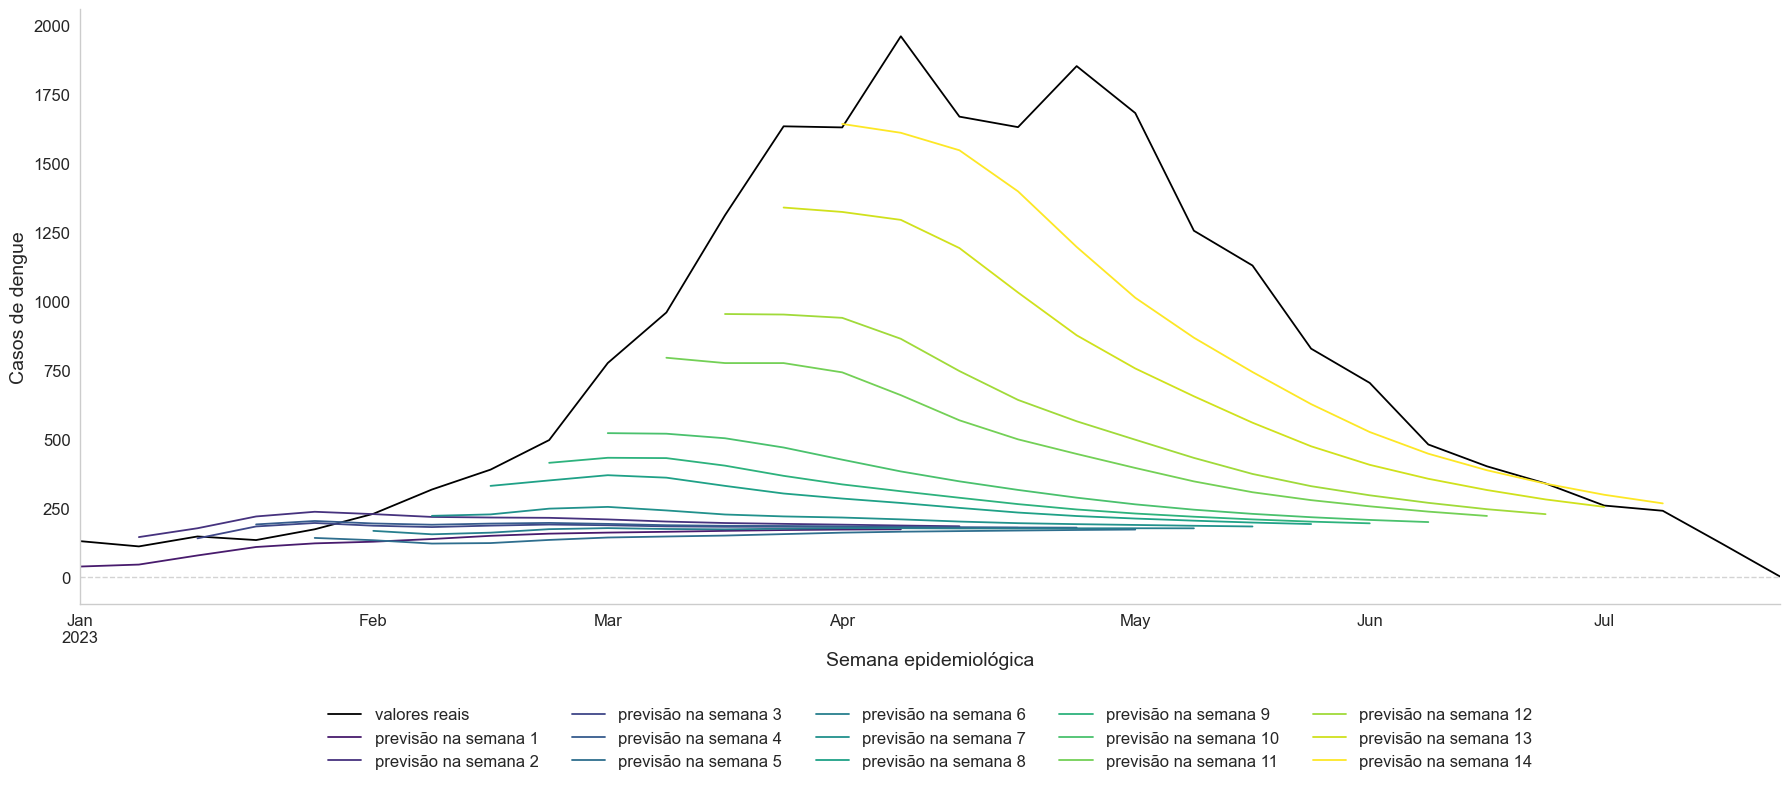

In [86]:
forecasts_pre = m_arma42.forecast(H) # previsão do modelo apenas com os dados de treinamento
arma42_results = pd.concat([test_data,forecasts_pre], axis=1)
arma42_results.rename(columns={'predicted_mean' : '2023S1', "casos" : "valores reais"}, inplace=True)
arma42_metrics, arma42_results = generate_forecasts(m_arma42, steps=H, results = arma42_results, n_predictions=n_predictions) # atualização iterativa dos dados utilizados para realizar a previsão
plot_forecasts(arma42_results, n_predictions) #, output_file='images/arma42_detail.png')

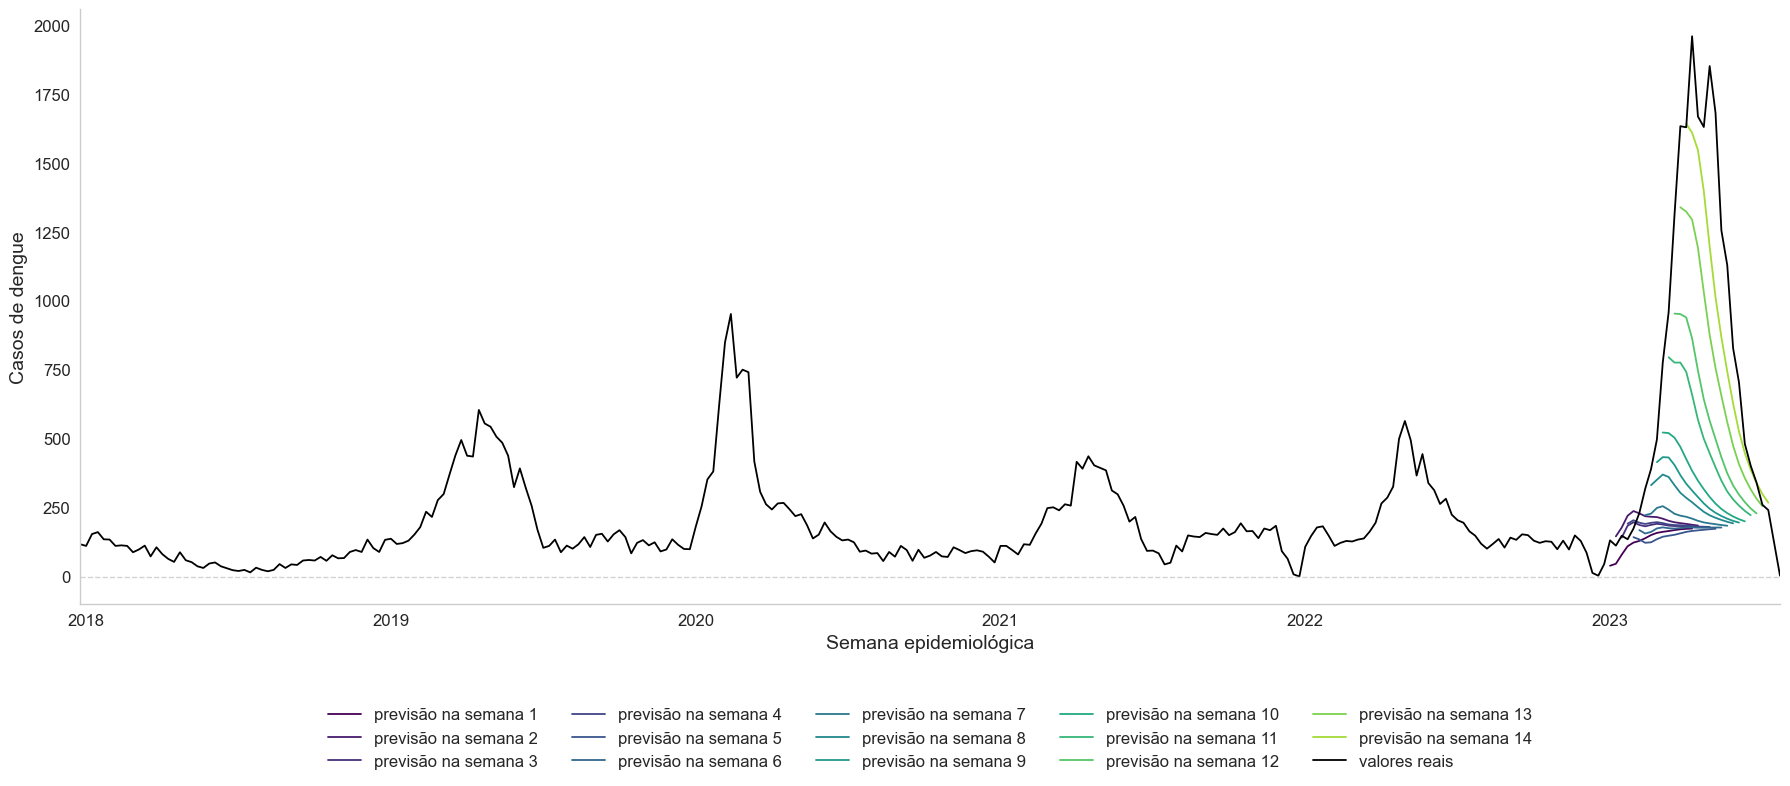

In [87]:
plot_results(arma42_results) #, output_file='images/nowcasting_lineplot_arma42.png')

In [88]:
pd.DataFrame(arma42_metrics).style.format({
                                        "MAE" : "{:.3f}", 
                                        "RMSE" : "{:.3f}", 
                                        "MASE" : "{:.3f}", 
                                        "FB" : "{:.3f}", 
                                        "AIC" : "{:.3f}", 
})#.to_excel('metrics_arma42_h4.xlsx')

,MAE,RMSE,MASE,FB,AIC
0,622.492,884.902,19.128,74.652,2786.881
1,724.621,967.783,22.301,79.700,2796.943
2,833.112,1057.865,25.630,81.288,2806.519
3,962.581,1145.478,29.680,86.428,2817.502
4,1012.044,1166.386,31.181,85.347,2827.493
5,1030.905,1163.873,31.676,82.755,2838.743
6,1005.106,1127.538,30.688,78.540,2852.340
7,996.933,1102.241,30.303,76.648,2863.436
8,956.757,1053.072,28.840,73.619,2876.011
9,787.213,884.007,23.095,61.758,2914.252


### ARMA (3,2)

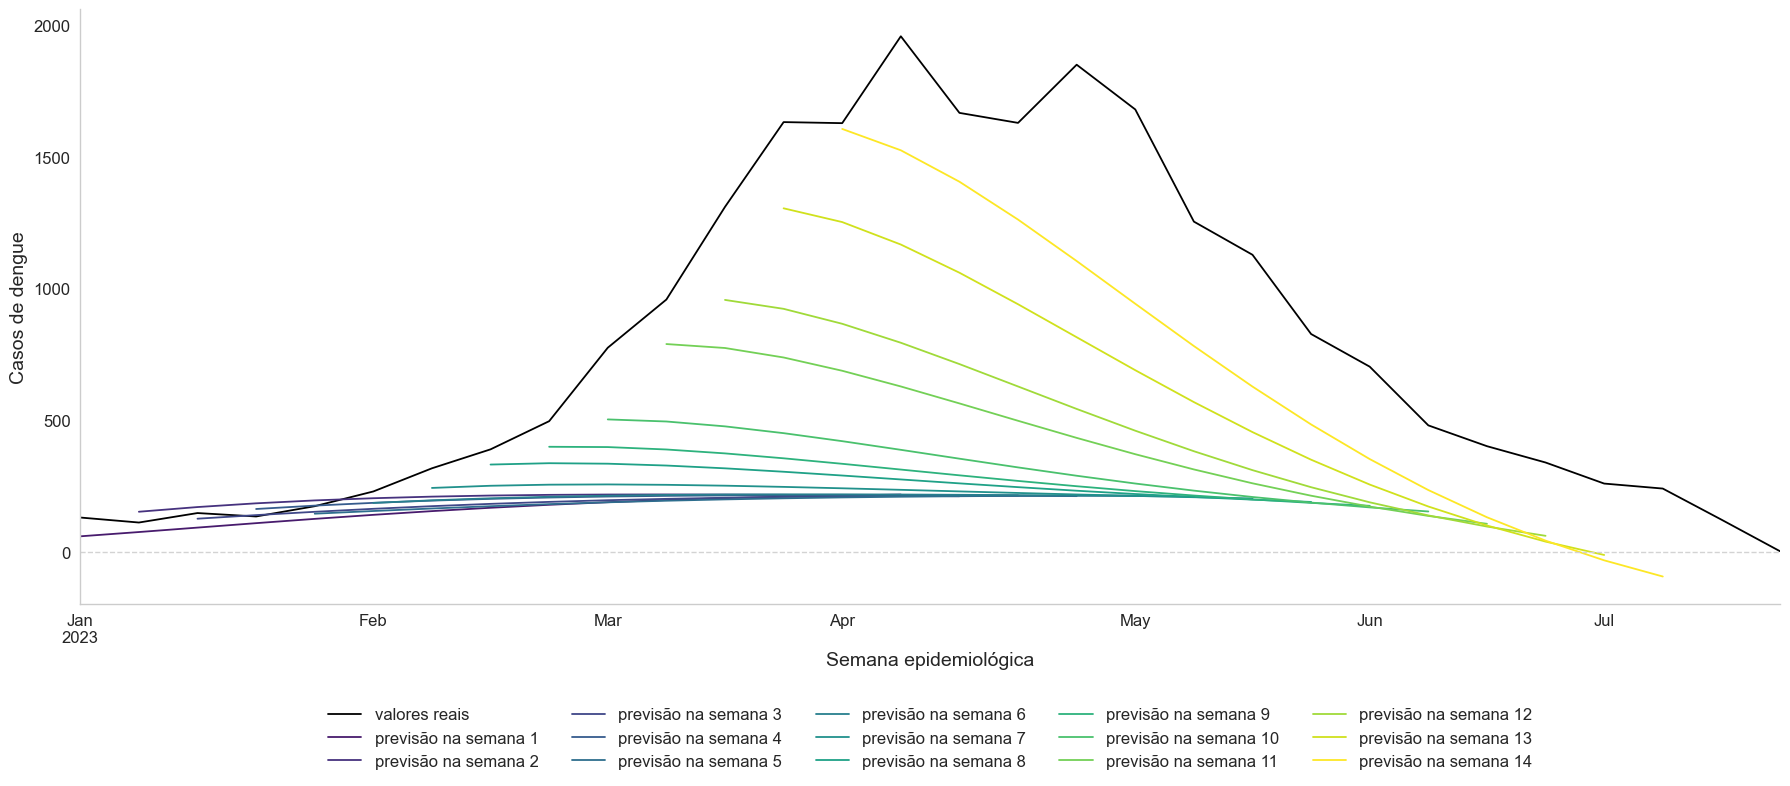

In [89]:
forecasts_pre = m_arma32.forecast(H) # previsão do modelo apenas com os dados de treinamento
arma32_results = pd.concat([test_data,forecasts_pre], axis=1)
arma32_results.rename(columns={'predicted_mean' : '2023S1', "casos" : "valores reais"}, inplace=True)
arma32_metrics, arma32_results = generate_forecasts(m_arma32, steps=H, results = arma32_results, n_predictions=n_predictions, refit=False)
plot_forecasts(arma32_results, n_predictions) #, output_file='images/arma32_detail.png')

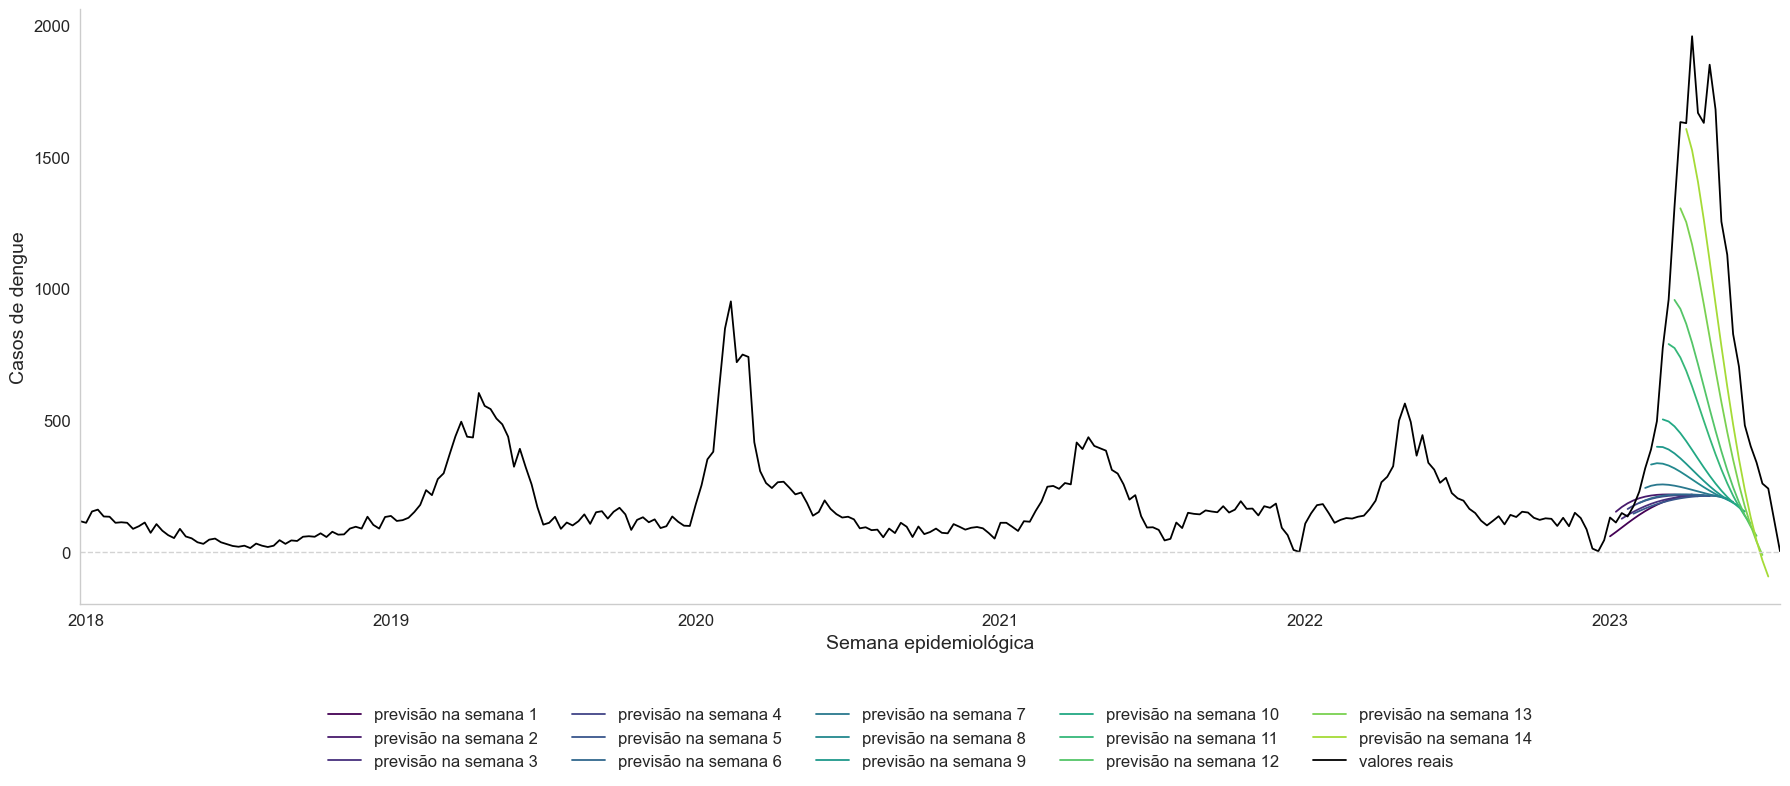

In [90]:
plot_results(arma32_results)

In [91]:
pd.DataFrame(arma32_metrics).style.format({
                                        "MAE" : "{:.3f}", 
                                        "RMSE" : "{:.3f}", 
                                        "MASE" : "{:.3f}", 
                                        "FB" : "{:.3f}", 
                                        "AIC" : "{:.3f}", 
})#.to_excel('metrics_arma32_h4.xlsx')

,MAE,RMSE,MASE,FB,AIC
0,609.710,869.790,18.735,74.330,2792.590
1,711.201,948.371,21.888,79.198,2802.901
2,810.968,1034.877,24.948,79.837,2812.687
3,921.670,1108.125,28.419,82.755,2822.622
4,974.240,1132.556,30.017,82.159,2832.558
5,1009.844,1142.979,31.029,81.064,2842.962
6,1007.672,1125.715,30.766,78.741,2854.947
7,1008.301,1107.962,30.648,77.522,2865.972
8,971.836,1061.256,29.294,74.780,2879.636
9,828.371,912.716,24.303,64.987,2921.172


## Considerações Finais

Conforme os resultados obtidos, embora o modelo ARMA (3,2) tenha tido um desempenho melhor considerando os erros, seu desempenho caiu consideravelmente em relação ao modelo ARMA (4,2), que conseguiu se ajustar melhor aos dados ao longo do tempo.<br>
Verifica-se que quanto maior o horizonte de previsão, menor a acurácia do modelo, o que de fato é esperado pelo aumento da incerteza, fenômeno que pode ter sido potencializado pela natureza heterocedástica dos dados. Também observa-se que a atualização do modelo com novos dados contribui de forma positiva para melhorar o desempenho do modelo.<br>
O modelo ainda pode ser melhorado para lidar com a heterocedasticidade encontrada nos dados, com a inclusão de variáveis auxiliares, e pode ser utilizado como base para a construção de modelos mais sofisticados.<br>